# Named entity recognition


In [1]:
import collections
import json
import matplotlib.pyplot as plt
import nltk
import os
import os.path
import pandas as pd
import requests
import time
import tqdm
import urllib.request

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mmastalerczyk/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
clarin_url = 'http://ws.clarin-pl.eu/nlprest2/base'

In [60]:
RESULT_DIRECTORY = './ccl'

1. Sort bills according to their size and take top 50 (largest) bills.

In [3]:
all_acts = {}

for root, _, files in os.walk('./ustawy'):
    for file_name in files:
        path = os.path.join(root, file_name)
        with open(path, encoding='utf-8') as file:
            content = file.read()
            all_acts[path] = content

In [4]:
top_acts = {
    pair[0]: pair[1]
    for pair
    in sorted(all_acts.items(), key=lambda pair: -len(pair[1]))[:50]
}

In [6]:
top_acts.keys()

dict_keys(['./ustawy/2000_696.txt', './ustawy/2001_627.txt', './ustawy/1996_465.txt', './ustawy/1997_555.txt', './ustawy/2002_1689.txt', './ustawy/2000_1186.txt', './ustawy/1998_1118.txt', './ustawy/1997_117.txt', './ustawy/2001_1070.txt', './ustawy/2001_1368.txt', './ustawy/1997_714.txt', './ustawy/2001_499.txt', './ustawy/2000_991.txt', './ustawy/2003_1750.txt', './ustawy/2001_1545.txt', './ustawy/2001_1229.txt', './ustawy/2000_1268.txt', './ustawy/1994_195.txt', './ustawy/1997_926.txt', './ustawy/2000_1104.txt', './ustawy/2003_2277.txt', './ustawy/1997_553.txt', './ustawy/2004_2065.txt', './ustawy/2004_1693.txt', './ustawy/2004_880.txt', './ustawy/2004_177.txt', './ustawy/2003_423.txt', './ustawy/1997_349.txt', './ustawy/2000_1315.txt', './ustawy/1999_930.txt', './ustawy/1994_591.txt', './ustawy/1996_110.txt', './ustawy/1997_557.txt', './ustawy/1999_95.txt', './ustawy/2004_2533.txt', './ustawy/2001_1381.txt', './ustawy/2000_136.txt', './ustawy/1996_460.txt', './ustawy/2001_1438.txt'

2. Use the lemmatized and sentence split documents (from ex. 5) to identify the expressions that consist of consecutive words starting with a capital letter (you will have to look at the inflected form of the word to check its capitalization) that do not occupy the first position in a sentence. E.g. the sentence:
 > Wczoraj w Krakowie miało miejsce spotkanie prezydentów Polski i Stanów Zjednoczonych.

should yield the following entries: Kraków, Polska, Stan Zjednoczony.

In [11]:
def lemmatize(text):
    sentences = nltk.tokenize.sent_tokenize(text, language='polish')
    sentences = [nltk.tokenize.word_tokenize(sentence, language='polish') for sentence in sentences]
    request = [[[word, True] for word in sentence] for sentence in sentences]
    response = request(
        lambda: requests.post('http://localhost:9003?output_format=jsonl', json=[request]).json()
    )

    lemmatized_text = []
    for raw_sentence, lemmatized_sentence in zip(sentences, response):
        resulting_sentence = []
        for raw_token, lemmatized_token in zip(raw_sentence, lemmatized_sentence):
            _, lemmatized_token, category = lemmatized_token
            category = category.split(':')[0]
            resulting_sentence.append([(raw_token, lemmatized_token, category)])

        lemmatized_text.append([resulting_sentence])

    return lemmatized_content

In [13]:
lemmatized_acts = {}

with tqdm.tqdm(total=len(top_acts), position=0, leave=True) as pbar:
    for path, content in list(top_acts.items()):
        lemmatized_acts[path] = lemmatize(content)
        pbar.update()

100%|██████████| 50/50 [20:41<00:00, 24.83s/it]


In [14]:
list(lemmatized_acts.values())[0][:5]


[[('Dz.U', 'dziennik ustaw', 'brev'), ('.', '.', 'interp')],
 [('z', 'z', 'prep'),
  ('1998', '1998', 'adj'),
  ('r.', 'R', 'brev'),
  ('Nr', 'numer', 'brev'),
  ('106', '106', 'num'),
  (',', ',', 'interp'),
  ('poz.', 'poz.', 'subst'),
  ('668', '668', 'num'),
  ('USTAWA', 'ustawa', 'subst'),
  ('z', 'z', 'prep'),
  ('dnia', 'dzień', 'subst'),
  ('24', '24', 'adj'),
  ('lipca', 'lipiec', 'subst'),
  ('1998', '1998', 'adj'),
  ('r.', 'r.', 'subst'),
  ('o', 'o', 'prep'),
  ('zmianie', 'zmiana', 'subst'),
  ('niektórych', 'niektóry', 'adj'),
  ('ustaw', 'ustawa', 'subst'),
  ('określających', 'określać', 'pact'),
  ('kompetencje', 'kompetencja', 'subst'),
  ('organów', 'organ', 'subst'),
  ('administracji', 'administracja', 'subst'),
  ('publicznej', 'publiczny', 'adj'),
  ('-', '-', 'interp'),
  ('w', 'w', 'prep'),
  ('związku', 'związek', 'subst'),
  ('z', 'z', 'prep'),
  ('reformą', 'reforma', 'subst'),
  ('ustrojową', 'ustrojowy', 'adj'),
  ('państwa', 'państwo', 'subst'),
  ('Art.

3. Compute the frequency of each identified expression and print 50 results with the largest number of occurrences.


In [16]:
def is_capitalized(word):
    is_roman_numeral = all([character in ['I', 'V', 'X', 'L', 'C', 'D', 'M'] for character in word])
    if is_roman_numeral:
        return False
    for component in word.split():
        if not component[:1].isupper():
            return False
    return True


def count_capitalized_expressions(texts, raw=False):
    expressions = collections.defaultdict(int)
    current_expression = None
    for text in texts:
        for sentence_index, sentence in enumerate(text):
            for index, word in enumerate(sentence):
                raw_token, lemmatized_token, category = word

                # only consider the first word in a sentence if it's capitalized in its basic format as well
                if index == 0:
                    if is_capitalized(lemmatized_token) and is_capitalized(raw_token):
                        current_expression = raw_token if raw else lemmatized_token
                    continue

                # break the current streak when you ecounter interpuction
                if category in ['interp', 'xxx', 'ign']:
                    if current_expression is not None:
                        if not raw:
                            current_expression = current_expression.lower()
                        expressions[current_expression] += 1
                        current_expression = None
                    continue

                # begin new streak
                if is_capitalized(raw_token):
                    if current_expression is None:
                        current_expression = raw_token if raw else lemmatized_token
                    else:
                        current_expression = f'{current_expression} {raw_token if raw else lemmatized_token}'
                # break current streak if you encounter a lower-case word
                elif current_expression is not None:
                    if not raw:
                        current_expression = current_expression.lower()
                    expressions[current_expression] += 1
                    current_expression = None

            # clean up at the end of a sentence
            if current_expression is not None:
                if not raw:
                    current_expression = current_expression.lower()
                expressions[current_expression] += 1
                current_expression = None
    return expressions

In [17]:
results = count_capitalized_expressions(lemmatized_acts.values())
sorted(results.items(), key=lambda pair: -pair[1])[:50]

[('numer', 7469),
 ('minister', 1273),
 ('dziennik ustaw', 1044),
 ('artykuł', 1016),
 ('rzeczpospolita polski', 758),
 ('kodeks', 524),
 ('przepis', 475),
 ('policja', 462),
 ('skarb państwo', 393),
 ('prawo', 355),
 ('organ', 348),
 ('kasa chory', 301),
 ('unia europejski', 293),
 ('straż graniczny', 288),
 ('minister obrona narodowy', 284),
 ('rada minister', 280),
 ('minister sprawiedliwość', 277),
 ('państwowy komisja wyborczy', 267),
 ('państwowy straż pożarny', 240),
 ('minister finanse', 239),
 ('zakład', 230),
 ('fundusz', 205),
 ('rada', 192),
 ('zmiana', 183),
 ('prezes urząd', 183),
 ('dzieje u', 175),
 ('urząd patentowy', 172),
 ('dzieje ustawa', 164),
 ('azot', 162),
 ('rozdział', 152),
 ('pozostały', 146),
 ('urząd ochrona państwo', 141),
 ('tkanina', 141),
 ('prezes rada minister', 134),
 ('inspektor nadzór wewnętrzny', 115),
 ('efta', 114),
 ('komisja', 110),
 ('nawóz', 110),
 ('biuro', 109),
 ('administracja', 107),
 ('europejski obszar gospodarczy', 106),
 ('p2o5', 1

4. Apply the NER algorithm to identify the named entities in the same set of documents (not lemmatized) using the n82 model.


In [61]:
from lpmn_client import Task, Config


def start_task(text):
    task = Task(lpmn='any2txt|wcrft2|liner2({"model":"n82"})')
    task.email = 'mastalerczyk@student.agh.edu.pl'

    data = {
        'lpmn': 'any2txt|wcrft2|liner2({"model":"n82"})', 
        'user': 'mastalerczyk@student.agh.edu.pl', 
        'text': text
    }

    return requests.post(
        url=Config.get("base_url") + "/startTask/",
        json=data).text


def monitor_task(task_id, max_attempts=5):
    status = 'QUEUE'
    value = None

    attempts = 0
    while status != 'DONE' and attempts < max_attempts:
        response = requests.get(
            url=Config.get("base_url") + f"/getStatus/{task_id}"
        ).json()
        status = response['status']
        if status == 'DONE':
            value = response['value']
        attempts += 1
        time.sleep(0.5)

    if status == 'ERROR':
        print(f'Error: {result}')

    return value

In [62]:
task_ids = [
    start_task(text)
    for _, text
    in tqdm.tqdm(top_acts.items())
]

100%|██████████| 50/50 [00:08<00:00,  6.09it/s]


In [63]:
task_ids

['f72c8f46-b952-49cc-803e-df3af7f72f68',
 '8c8df291-97ce-47e5-aca1-7981b4eac630',
 '0ff12c6c-bd89-425e-b8c7-78eabf8577ea',
 '446618f8-a4f9-4dd4-b8c6-8bf4b6eabb9d',
 '132144e2-2bca-47a8-bde1-bc43aee5d19b',
 '09d1f4fb-7d79-4faf-a52e-0295cc8fb779',
 '65307708-73b6-4367-9695-01230692dfc2',
 '5d947808-67fe-4be1-a701-d184603a36e2',
 '7936debe-2a9d-4995-bb29-716e072912b3',
 'c36dd70d-4eae-45f3-8f7a-8099aaa3ed66',
 '4c6ade1c-71a6-458b-af77-2d88d2e53ab3',
 '0e1d693a-eca8-4362-9f11-dadd62320ea4',
 '94a5ed10-69ff-4f44-975a-a1e9ea50952d',
 '109abe8c-ce34-48c8-bbcb-07508a4393b5',
 'ed73cf12-605c-4986-b9bf-1bc49ad9daed',
 '859c57d3-a617-4619-a51c-c2f9bf882178',
 '3fcd0d3b-afd1-4a47-a8de-88a6d51c1fb0',
 'feff537b-3643-41ab-b22c-3d26bca9320a',
 'b5c953e3-25dc-4214-bfd6-40656616d835',
 'de353b0d-28c3-42ef-8a95-ddc36b54a577',
 '1a7f6e1c-2eaf-4a22-807e-209f84efe1cb',
 '55ee2ada-a8c6-4ad8-aeff-2fdf61317b7b',
 '4d55e576-198a-48d6-abcb-a5b1331ccc6c',
 '57467dbb-1b6c-46a5-a8f0-3e0bdb8837be',
 'd310e777-978f-

In [64]:
done_tasks = set()

with tqdm.tqdm(total=len(top_acts), position=0, leave=True) as pbar:
    while pbar.n < pbar.total:
        for path, task_id in list(zip(top_acts.keys(), task_ids)):
            if task_id in done_tasks:
                continue

            result = monitor_task(task_id)

            if result == None:
                continue

            file_id = result[0]['fileID']
            response = requests.get(
                url=Config.get("base_url") + f'/download/{file_id}')

            file_name = os.path.relpath(path, './ustawy')
            file_name = file_name.replace('.txt', '.ccl')

            with open(f'{RESULT_DIRECTORY}/{file_name}', 'w', encoding='utf-8') as file:
                file.write(response.content.decode('utf-8'))

            done_tasks.add(task_id)

            pbar.update()

100%|██████████| 50/50 [12:16<00:00, 14.72s/it]  


5. Plot the frequency (histogram) of the coarse-grained classes (e.g. nam_adj, nam_eve, nam_fac).


In [66]:
class Token:
    def __init__(self, orth, base, ctag):
        self.orth = orth
        self.base = base
        self.ctag = ctag

    def get_orth(self):
        return self.orth

    def get_base(self):
        return self.base

    def get_ctag(self):
        return self.ctag


class Annotation:
    def __init__(self, category, tokens):
        self.category = category
        self.tokens = tokens
        self.lemma = self.get_orth()

    def get_category(self):
        return self.category

    def get_tokens(self):
        return self.tokens

    def get_orth(self):
        return " ".join([token.get_orth() for token in self.tokens])

    def get_base(self):
        return " ".join([token.get_base() for token in self.tokens])

    def get_ctag(self):
        return " ".join([token.get_ctag() for token in self.tokens])

    def get_space(self):
        return " ".join(["True" for token in self.tokens])

    def get_lemma(self):
        return self.lemma

    def set_lemma(self, lemma):
        self.lemma = lemma

    def __str__(self):
        return "[%s] %s" % (self.get_category(), self.get_lemma())


In [67]:
import xml.etree.ElementTree as ET

def sentence_ner(sentence):
    channels = {}
    for token in sentence.iter("tok"):
        orth = token.find("./orth").text
        base = token.find("./lex/base").text
        ctag = token.find("./lex/ctag").text
        t = Token(orth, base, ctag)
        for channel in token.iter("ann"):
            index = int(channel.text)
            chan = channel.attrib["chan"]
            if index > 0:
                channels.setdefault(chan, {}) \
                        .setdefault(index, []) \
                        .append(t)

    annotations = []
    for (ann_type, group) in channels.items():
        for tokens in group.values():
            an = Annotation(ann_type, tokens)
            annotations.append(an)

    return annotations


def ccl_ner(ccl):
    tree = ET.parse(ccl)
    annotations = []
    for sentence in tree.iter("sentence"):
        annotations += sentence_ner(sentence)
    return annotations

In [68]:
coarse_grained_class_counter = collections.defaultdict(int)

for file in tqdm.tqdm([file for file in os.listdir(RESULT_DIRECTORY) if file.endswith('.ccl')]):
    annotations = ccl_ner(os.path.join(RESULT_DIRECTORY, file))
    for annotation in annotations:
        category = annotation.get_category()
        coarse_category = '_'.join(category.split('_')[:2])
        coarse_grained_class_counter[coarse_category] += 1


100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


<BarContainer object of 9 artists>

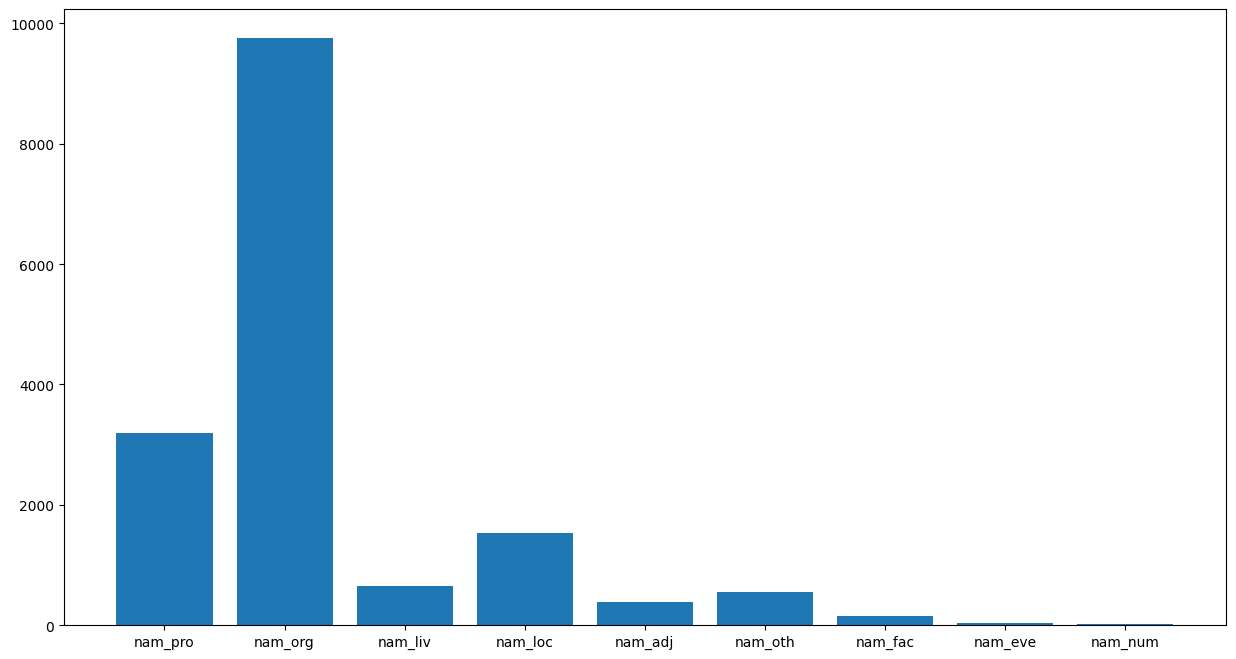

In [69]:
plt.figure(figsize=(15, 8))
plt.bar(coarse_grained_class_counter.keys(), coarse_grained_class_counter.values())

6. Display 10 most frequent Named Entities for each coarse-grained type.


In [70]:
coarse_grained_class_entity_counter = collections.defaultdict(lambda: collections.defaultdict(int))

for file in tqdm.tqdm([file for file in os.listdir(RESULT_DIRECTORY) if file.endswith('.ccl')]):
    annotations = ccl_ner(os.path.join(RESULT_DIRECTORY, file))
    for annotation in annotations:
        category = annotation.get_category()
        entity = annotation.get_lemma()
        coarse_category = '_'.join(category.split('_')[:2])
        coarse_grained_class_entity_counter[coarse_category][entity] += 1

100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


In [71]:

for category, entities in coarse_grained_class_entity_counter.items():
    print('-----------------------------------------------------------')
    for entity, count in list(sorted(entities.items(), key=lambda pair: -pair[1]))[:10]:
        print(f'| {category} | {str(count).ljust(4)} | {entity.ljust(38)} |')
print('-----------------------------------------------------------')

-----------------------------------------------------------
| nam_pro | 1534 | Dz . U .                               |
| nam_pro | 80   | Dz . Urz                               |
| nam_pro | 71   | Ordynacja podatkowa                    |
| nam_pro | 64   | Kodeksu karnego                        |
| nam_pro | 62   | Monitor Polski                         |
| nam_pro | 51   | Spraw Wewnętrznych                     |
| nam_pro | 35   | Kodeksu postępowania administracyjnego |
| nam_pro | 33   | Kodeksu postępowania karnego           |
| nam_pro | 32   | Kodeksu postępowania cywilnego         |
| nam_pro | 26   | Natura 2000                            |
-----------------------------------------------------------
| nam_org | 295  | Skarbu Państwa                         |
| nam_org | 291  | Unii Europejskiej                      |
| nam_org | 261  | Rada Ministrów                         |
| nam_org | 239  | Państwowej Straży Pożarnej             |
| nam_org | 233  | Minister Sprawiedliwo

7. Display 50 most frequent Named Entities including their count and fine-grained type.


In [72]:
fine_grained_class_entity_counter = collections.defaultdict(int)

for file in tqdm.tqdm([file for file in os.listdir(RESULT_DIRECTORY) if file.endswith('.ccl')]):
    annotations = ccl_ner(os.path.join(RESULT_DIRECTORY, file))
    for annotation in annotations:
        category = annotation.get_category()
        entity = annotation.get_lemma()
        fine_grained_class_entity_counter[(entity, category)] += 1

100%|██████████| 50/50 [00:42<00:00,  1.16it/s]


In [73]:
sorted_fine_grained_class_entity_counter = sorted(
    fine_grained_class_entity_counter.items(),
    key=lambda pair: -pair[1]
)

print('-----------------------------------------------------------------------------------')
for entity, count in sorted_fine_grained_class_entity_counter[:50]:
    entity, category = entity
    print(f'| {str(count).ljust(4)} | {entity.ljust(48)}| {category.ljust(22)} |')
print('-----------------------------------------------------------------------------------')


-----------------------------------------------------------------------------------
| 1534 | Dz . U .                                        | nam_pro_media_periodic |
| 812  | Rzeczypospolitej Polskiej                       | nam_loc_gpe_country    |
| 295  | Skarbu Państwa                                  | nam_org_institution    |
| 293  | zł                                              | nam_oth_currency       |
| 290  | Unii Europejskiej                               | nam_org_organization   |
| 261  | Rada Ministrów                                  | nam_org_institution    |
| 233  | Minister Sprawiedliwości                        | nam_org_institution    |
| 213  | Prezes Rady Ministrów                           | nam_org_institution    |
| 205  | Państwowej Straży Pożarnej                      | nam_org_organization   |
| 162  | Minister Obrony Narodowej                       | nam_org_institution    |
| 152  | Minister Finansów                               | nam_org_instituti

9. Answer the following questions:
 - Which of the method (counting expressions with capital letters vs. NER) worked better for the task concerned with identification of the proper names?
 
    NER works better, by default it's the purpose of this tool, it gives more information about categories.
 
 - What are the drawbacks of the method based on capital letters?

    It has worse accuracy, it requires tokenized text, in tables anything with that starts with capital letters may be wrong classified, problems with handling stop words
    
    Nie jest taka dokładna (znajdowane jest wiele niepoprawnych wyników). Tekst musi być bardzo dobrze podzielony na tokeny. W tym zadaniu wykorzystaliśmy stokenizowany tekst, natomiast tagi stworzone wcześniej nie zostały użyte.
 
 - What are the drawbacks of the method based on NER?
 
    Time consuming model evaluation and it requires a lot of space. Sometimes we may notice duplicates because of different flectional form.
 
 - Which of the coarse-grained NER groups has the best and which has the worst results? Try to justify this observation.

    With nanm_org we have probably the best result. nam_loc we also have some reasonable result, but there we can observe some duplications, likewise nam_adj.

    I think most of the result of nam_pro should have different categories, I wouldn't say it match category 'product'. As well nam_fac - 'Inspektor Nadzoru Wewnętrznego' or 'Komendant Główny' don't sound like facility names. In num_eve we have mixed result, some of them are well classified like 'EURO' or 'II wojny światowej', but then we have for example 'Ochrony Roślin' which doesn't make sene.
 
 - Do you think NER is sufficient for identifying different occurrences of the same entity (i.e. consider "USA" and "Stany Zjednoczone" and "Stany Zjednoczone Ameryki Północnej")? If not, can you suggest an algorithm or a tool that would be able to group such names together?
 
     NER can't deal with different forms of words or synonyms, we should use NER only to analyse base forms of words and use some synonym dictionary to identify different forms, maybe utilize Słowosieć.
 
 
 - Can you think of a real world problem that would benefit the most from application of Named Entity Recognition algorithm?

    1) Analysis of post in social media
    2) Chatbots / SIRI - understandig what person that interacts with the model wants